In [1]:
! rm -rf /home/csck/autosklearn-regressor-moneyball/tmp_folder

/home/csck/miniconda3/envs/ml-auto/lib/python3.9/site-packages/autosklearn/__init__.py:5: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


✅ Training set: 1812 rows, 51 columns
✅ Test set: 453 rows, 45 columns

🔧 Applied enhanced feature engineering. Train shape: (1812, 60), Test shape: (453, 54)
🧩 Using 34 features (excluding time features).
🔍 Running AutoSklearnRegressor...
[WARNING] [2025-07-03 20:30:43,850:Client-AutoMLSMBO(1)::moneyball] Dataset moneyball already in meta-data. Removing occurence.

📊 Auto-Sklearn Evaluation (Training Set):
   MAE  : 2.66920
   RMSE : 3.35006
   R²   : 0.93484


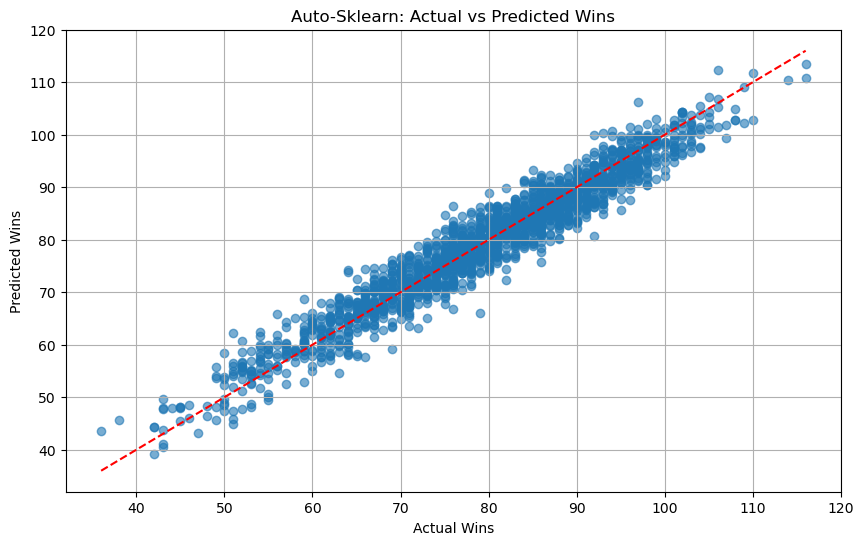

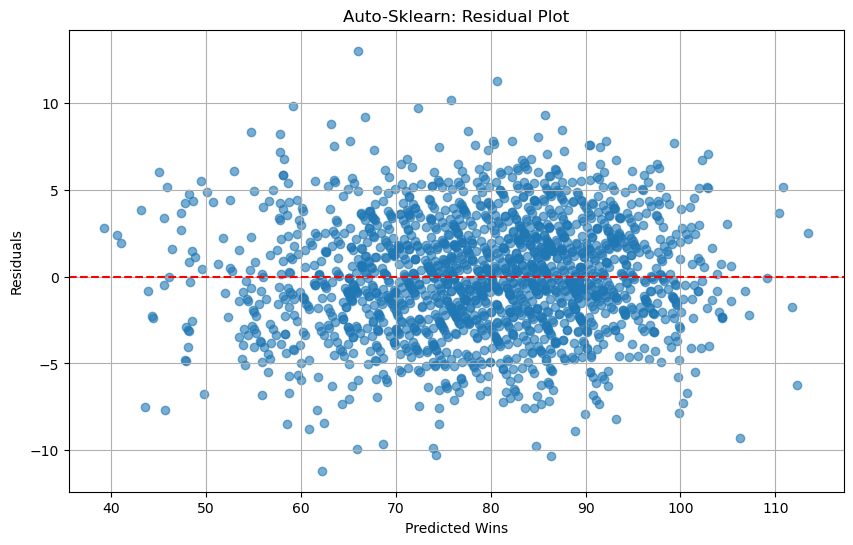

💾 Submission saved: submission_autosklearn.csv


In [2]:
# -------------------------------
# ✅ Importing Libraries
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

import autosklearn.regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# -------------------------------
# ✅ Data Loading
# -------------------------------
train_df = pd.read_csv('/home/csck/moneyball-sctpds1f/unzipped_moneyball/train.csv')
test_df = pd.read_csv('/home/csck/moneyball-sctpds1f/unzipped_moneyball/test.csv')
print(f"✅ Training set: {train_df.shape[0]} rows, {train_df.shape[1]} columns")
print(f"✅ Test set: {test_df.shape[0]} rows, {test_df.shape[1]} columns\n")

# -------------------------------
# ✅ Feature Engineering
# -------------------------------
def create_features(df):
    df = df.copy()
    df['pyth_wins'] = (df['R']**1.83 / (df['R']**1.83 + df['RA']**1.83)) * df['G']
    df['run_diff'] = df['R'] - df['RA']
    df['run_diff_per_game'] = df['run_diff'] / df['G']
    df['runs_per_game'] = df['R'] / df['G']
    df['runs_allowed_per_game'] = df['RA'] / df['G']
    df['OBP'] = (df['H'] + df['BB']) / (df['AB'] + df['BB'])
    singles = df['H'] - df['2B'] - df['3B'] - df['HR']
    total_bases = singles + 2 * df['2B'] + 3 * df['3B'] + 4 * df['HR']
    df['SLG'] = total_bases / df['AB']
    df['RS'] = -804.6 + 2737.8 * df['OBP'] + 1584.9 * df['SLG']
    df['wins_est'] = 80.8814 + 0.1058 * (df['RS'] - df['RA'])
    return df

train_df = create_features(train_df)
test_df = create_features(test_df)
print(f"🔧 Applied enhanced feature engineering. Train shape: {train_df.shape}, Test shape: {test_df.shape}")

# -------------------------------
# ✅ Feature Preparation
# -------------------------------
excluded = ['ID', 'W'] + [col for col in train_df.columns if col.startswith(('era_', 'decade_'))]
available_features = [f for f in train_df.columns if f not in excluded and f in test_df.columns]
print(f"🧩 Using {len(available_features)} features (excluding time features).")

X_train = train_df[available_features].copy()
y_train = train_df['W']
X_test = test_df[available_features].copy()

# -------------------------------
# ✅ AutoSklearn Regressor
# -------------------------------
print("🔍 Running AutoSklearnRegressor...")
automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=1500,        # ⏱️ 25 minutes total
    per_run_time_limit=150,             # ⏱️ 2.5 minutes per model
    tmp_folder='/home/csck/autosklearn-regressor-moneyball/tmp_folder',
)

automl.fit(X_train, y_train, dataset_name="moneyball")

# -------------------------------
# ✅ Evaluation on Training Set
# -------------------------------
train_preds = automl.predict(X_train)
print("\n📊 Auto-Sklearn Evaluation (Training Set):")
print(f"   MAE  : {mean_absolute_error(y_train, train_preds):.5f}")
print(f"   RMSE : {mean_squared_error(y_train, train_preds, squared=False):.5f}")
print(f"   R²   : {r2_score(y_train, train_preds):.5f}")

# -------------------------------
# 📈 Visualizations
# -------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(y_train, train_preds, alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.xlabel("Actual Wins")
plt.ylabel("Predicted Wins")
plt.title("Auto-Sklearn: Actual vs Predicted Wins")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(train_preds, y_train - train_preds, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted Wins")
plt.ylabel("Residuals")
plt.title("Auto-Sklearn: Residual Plot")
plt.grid(True)
plt.show()

# -------------------------------
# ✅ Test Predictions and Export
# -------------------------------
final_test_preds = automl.predict(X_test)
submission = pd.DataFrame({
    'ID': test_df['ID'],
    'W': np.round(final_test_preds).astype(int)
})
submission.to_csv('submission_autosklearn.csv', index=False)
print("💾 Submission saved: submission_autosklearn.csv")


In [3]:
print("\n🏆 Auto-Sklearn Leaderboard (Top Models):")
print(automl.leaderboard())


🏆 Auto-Sklearn Leaderboard (Top Models):
          rank  ensemble_weight               type      cost   duration
model_id                                                               
26           1             0.60     ard_regression  0.067287   0.527846
118          2             0.02      liblinear_svr  0.068027   0.747787
10           3             0.16     ard_regression  0.068783  32.365854
104          4             0.18     ard_regression  0.071043  20.145429
13           5             0.02  gradient_boosting  0.080392   4.086201
64           6             0.02      random_forest  0.088207  33.450543


In [4]:
print("\n📦 Ensemble Model Weights:")
print(automl.get_models_with_weights())


📦 Ensemble Model Weights:
[(0.6, SimpleRegressionPipeline({'data_preprocessor:__choice__': 'feature_type', 'feature_preprocessor:__choice__': 'feature_agglomeration', 'regressor:__choice__': 'ard_regression', 'data_preprocessor:feature_type:numerical_transformer:imputation:strategy': 'median', 'data_preprocessor:feature_type:numerical_transformer:rescaling:__choice__': 'robust_scaler', 'feature_preprocessor:feature_agglomeration:affinity': 'euclidean', 'feature_preprocessor:feature_agglomeration:linkage': 'ward', 'feature_preprocessor:feature_agglomeration:n_clusters': 25, 'feature_preprocessor:feature_agglomeration:pooling_func': 'median', 'regressor:ard_regression:alpha_1': 1.3451538602739027e-05, 'regressor:ard_regression:alpha_2': 9.646408445137836e-08, 'regressor:ard_regression:fit_intercept': 'True', 'regressor:ard_regression:lambda_1': 2.5198380744059647e-07, 'regressor:ard_regression:lambda_2': 3.03274213695262e-10, 'regressor:ard_regression:n_iter': 300, 'regressor:ard_regres

In [5]:
print("\n🔍 Auto-Sklearn Final Ensemble Composition (Detailed):")
pprint(automl.show_models(), indent=4)


🔍 Auto-Sklearn Final Ensemble Composition (Detailed):
{   10: {   'cost': 0.06878275518164734,
            'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7fc1bf6feeb0>,
            'ensemble_weight': 0.16,
            'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice object at 0x7fc1bfc8aaf0>,
            'model_id': 10,
            'rank': 1,
            'regressor': <autosklearn.pipeline.components.regression.RegressorChoice object at 0x7fc1bfc8a4c0>,
            'sklearn_regressor': ARDRegression(alpha_1=0.0007694645303288904, alpha_2=6.907464089785431e-06,
              copy_X=False, lambda_1=5.725240603355948e-06,
              lambda_2=2.2747405613470773e-05,
              threshold_lambda=58747.57814168738, tol=5.818442213575333e-05)},
    13: {   'cost': 0.08039172167511399,
            'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.Data